In [4]:
! pip install tensorflow


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [1]:
# print keras version
import tensorflow as tf
print(tf.__version__)
#print tensorflow.keras version
print(tf.keras.__version__)

2025-04-11 10:30:19.436983: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744347619.450927   17220 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744347619.455188   17220 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744347619.467612   17220 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744347619.467639   17220 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744347619.467640   17220 computation_placer.cc:177] computation placer alr

2.19.0
3.9.2


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import multiprocessing
import gc
from scipy.stats import kurtosis, skew # Import kurtosis

data_cfg = {
    'Input_param_names': ['ambient',
                          'coolant',
                          'u_d',
                          'u_q',
                          'motor_speed',
                          #'torque',
                          'i_d',
                          'i_q'
                           ],
    'Target_param_names': ['pm',
                           'stator_yoke',
                           'stator_tooth',
                           'stator_winding'
                          ],
    # for ewm and statistical moments
    'downsample_rate': 1,
    'rolling_lookback': [120,600,3600,7200],
    'valset' : [78, 79, 81],
    'testset' : [27, 29, 30, 31, 65, 72, 4,  5,  6],
    'loss': 'mse',
    # profile ids to drop (don't need to actually exist)

    # paths
    'file_path': "measures.csv",
    'db_path': 'results.db',
    'model_dump_path': 'output/',
    'save_predictions': True,
    'random_seed': 2019,
    'downsample_val_test': True,
    'db_target_scheme': ['pm', 'stator_yoke', 'stator_tooth', 'stator_winding'],
}

# Load dataset
path = 'measures.csv'
conversion_table = {col: np.float32 for col in data_cfg['Input_param_names'] + data_cfg['Target_param_names']}
conversion_table.update({'profile_id': np.uint8})
dataset = pd.read_csv(path, dtype=conversion_table)

# Select relevant columns
x_cols = data_cfg['Input_param_names']
y_cols = data_cfg['Target_param_names']
dataset = dataset.loc[:, x_cols + y_cols + ['profile_id']]

# Calculate kurtosis for input and target columns
input_kurtosis = kurtosis(dataset[data_cfg['Input_param_names']], axis=0)
target_kurtosis = kurtosis(dataset[data_cfg['Target_param_names']], axis=0)
input_skewness = skew(dataset[data_cfg['Input_param_names']], axis=0)
target_skewness = skew(dataset[data_cfg['Target_param_names']], axis=0)

# Print kurtosis results
print("Kurtosis for input parameters:", input_kurtosis)
print("Kurtosis for target parameters:", target_kurtosis)
print("Skewness for input parameters:", input_skewness)
print("Skewness for target parameters:", target_skewness)                                             

# Create time column
# dataset['time'] = dataset.groupby('profile_id').cumcount() * 0.5

# Create extra features
def calculate_i_s(row):
    return np.sqrt(row['i_d']**2 + row['i_q']**2)

def calculate_u_s(row):
    return np.sqrt(row['u_d']**2 + row['u_q']**2)

def calculate_P_el(row):
    return row['i_s'] * row['u_s']

if set(['i_d', 'i_q', 'u_d', 'u_q']).issubset(set(dataset.columns.tolist())):
    dataset['i_s'] = dataset.apply(calculate_i_s, axis=1)
    dataset['u_s'] = dataset.apply(calculate_u_s, axis=1)
    dataset['P_el'] = dataset.apply(calculate_P_el, axis=1)

# Function to create lag features
def create_lag_features(args):
    df, lookback = args
    dfs = []
    for lback in range(lookback, lookback + 1, lookback):
        lag_feats = [
            df.shift(lback).astype(np.float32).fillna(df.iloc[0, :]).add_suffix(f'_lag_{lback}'),
            df.diff(periods=lback).astype(np.float32).fillna(df.iloc[0, :]).add_suffix(f'_lag_{lback}_diff')
        ]
        lag_feats += [
            abs(lag_feats[1]).astype(np.float32).add_suffix('_abs'),
            pd.DataFrame(df.values + lag_feats[0].values, columns=df.columns).add_suffix(f'_sum')
        ]
        dfs.append(pd.concat(lag_feats, axis=1))
    return pd.concat(dfs, axis=1)

# Function to create rolling features
def create_rolling_features(args):
    df, lookbacks = args
    dfs = []
    for lookback in lookbacks:
        dummy = np.zeros((lookback, len(df.columns)))
        dummy = pd.DataFrame(dummy, columns=df.columns)
        df = pd.concat([dummy, df], axis=0, ignore_index=True)
        ew_mean = pd.concat([df.ewm(span=lookback).mean().astype(np.float32).rename(columns=lambda c: c + '_ew_rolling_mean_' + str(lookback))], axis=1)
        ew_std = pd.concat([df.ewm(span=lookback).std().astype(np.float32).rename(columns=lambda c: c + '_ew_rolling_std_' + str(lookback))], axis=1)
        dfs.append(pd.concat([ew_mean, ew_std], axis=1).iloc[lookback + 1:, :].reset_index(drop=True))
    return pd.concat(dfs, axis=1)

# Apply feature creation in parallel
profiles_df = [dataset.loc[dataset['profile_id'] == int(p), :].reset_index(drop=True) for p in dataset['profile_id'].unique().tolist()]
with multiprocessing.Pool(2) as pool:
    lag_feats = pool.map(create_lag_features, [(df, data_cfg['downsample_rate']) for df in profiles_df])
    rolling_feats = pool.map(create_rolling_features, [(df, data_cfg['rolling_lookback']) for df in profiles_df])

# Merge features together
merged_profiles_df = [pd.concat([df] + [lag_feats[i], rolling_feats[i]], axis=1) for i, df in enumerate(profiles_df)]
dataset = pd.concat(merged_profiles_df, axis=0, ignore_index=True)

# Standardize the data
scaler = StandardScaler()
float_cols = x_cols + y_cols
dataset[float_cols] = scaler.fit_transform(dataset[float_cols].astype(float))

# Clean up
gc.collect()

# Save or return the processed dataset
dataset.to_csv('processed_dataset_base.csv', index=False)

Kurtosis for input parameters: [-0.13700199 -0.09900808 -0.29031873 -1.2430611  -1.1478026  -0.565284
  0.67749286]
Kurtosis for target parameters: [-0.7456558 -0.6297591 -0.9870949 -0.8996787]
Skewness for input parameters: [-0.34906548  1.04811466  0.14506117  0.31493244  0.38646251 -0.70730466
 -0.14650433]
Skewness for target parameters: [0.03831293 0.48100895 0.13761149 0.16766478]


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError

# Custom MSE metric
def mse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

# Load dataset
dataset = pd.read_csv('processed_dataset_base.csv')

# Define validation and test profile IDs
valset = [78, 79, 81]
testset = [27, 29, 30, 31, 65, 72, 4,  5,  6]

# Split dataset
train_profiles = dataset[~dataset['profile_id'].isin(valset + testset)]
val_profiles = dataset[dataset['profile_id'].isin(valset)]
test_profiles = dataset[dataset['profile_id'].isin(testset)]

y_cols = ['pm', 'stator_yoke', 'stator_tooth', 'stator_winding']

# **Filter out target-prefixed columns from x_cols**
def remove_prefixed_columns(x_cols, y_cols):
    """ Remove columns with prefixes matching y_cols """
    y_prefixes = tuple(f"{col}_" for col in y_cols)  # Add trailing underscore for prefix match
    return [col for col in x_cols if not col.startswith(y_prefixes)]

# Identify x_cols, excluding targets and profile_id
x_cols = dataset.columns[~dataset.columns.isin(y_cols + ['profile_id'])].tolist()
x_cols = remove_prefixed_columns(x_cols, y_cols)  # Remove prefixed columns

print("Final x_cols after prefix filtering:", x_cols)


Final x_cols after prefix filtering: ['ambient', 'coolant', 'u_d', 'u_q', 'motor_speed', 'i_d', 'i_q', 'i_s', 'u_s', 'P_el', 'ambient_lag_1', 'coolant_lag_1', 'u_d_lag_1', 'u_q_lag_1', 'motor_speed_lag_1', 'i_d_lag_1', 'i_q_lag_1', 'profile_id_lag_1', 'i_s_lag_1', 'u_s_lag_1', 'P_el_lag_1', 'ambient_lag_1_diff', 'coolant_lag_1_diff', 'u_d_lag_1_diff', 'u_q_lag_1_diff', 'motor_speed_lag_1_diff', 'i_d_lag_1_diff', 'i_q_lag_1_diff', 'profile_id_lag_1_diff', 'i_s_lag_1_diff', 'u_s_lag_1_diff', 'P_el_lag_1_diff', 'ambient_lag_1_diff_abs', 'coolant_lag_1_diff_abs', 'u_d_lag_1_diff_abs', 'u_q_lag_1_diff_abs', 'motor_speed_lag_1_diff_abs', 'i_d_lag_1_diff_abs', 'i_q_lag_1_diff_abs', 'profile_id_lag_1_diff_abs', 'i_s_lag_1_diff_abs', 'u_s_lag_1_diff_abs', 'P_el_lag_1_diff_abs', 'ambient_sum', 'coolant_sum', 'u_d_sum', 'u_q_sum', 'motor_speed_sum', 'i_d_sum', 'i_q_sum', 'profile_id_sum', 'i_s_sum', 'u_s_sum', 'P_el_sum', 'ambient_ew_rolling_mean_120', 'coolant_ew_rolling_mean_120', 'u_d_ew_rolli

In [7]:
x_cols

['ambient',
 'coolant',
 'u_d',
 'u_q',
 'motor_speed',
 'i_d',
 'i_q',
 'i_s',
 'u_s',
 'P_el',
 'ambient_lag_1',
 'coolant_lag_1',
 'u_d_lag_1',
 'u_q_lag_1',
 'motor_speed_lag_1',
 'i_d_lag_1',
 'i_q_lag_1',
 'profile_id_lag_1',
 'i_s_lag_1',
 'u_s_lag_1',
 'P_el_lag_1',
 'ambient_lag_1_diff',
 'coolant_lag_1_diff',
 'u_d_lag_1_diff',
 'u_q_lag_1_diff',
 'motor_speed_lag_1_diff',
 'i_d_lag_1_diff',
 'i_q_lag_1_diff',
 'profile_id_lag_1_diff',
 'i_s_lag_1_diff',
 'u_s_lag_1_diff',
 'P_el_lag_1_diff',
 'ambient_lag_1_diff_abs',
 'coolant_lag_1_diff_abs',
 'u_d_lag_1_diff_abs',
 'u_q_lag_1_diff_abs',
 'motor_speed_lag_1_diff_abs',
 'i_d_lag_1_diff_abs',
 'i_q_lag_1_diff_abs',
 'profile_id_lag_1_diff_abs',
 'i_s_lag_1_diff_abs',
 'u_s_lag_1_diff_abs',
 'P_el_lag_1_diff_abs',
 'ambient_sum',
 'coolant_sum',
 'u_d_sum',
 'u_q_sum',
 'motor_speed_sum',
 'i_d_sum',
 'i_q_sum',
 'profile_id_sum',
 'i_s_sum',
 'u_s_sum',
 'P_el_sum',
 'ambient_ew_rolling_mean_120',
 'coolant_ew_rolling_mean_1

In [8]:

X_train, y_train = train_profiles[x_cols].values, train_profiles[y_cols].values
X_val, y_val = val_profiles[x_cols].values, val_profiles[y_cols].values
X_test, y_test = test_profiles[x_cols].values, test_profiles[y_cols].values

# Lookback window
# lookback = 10  
lookback = 128

# Reshape function for CNN
def reshape_data(X, y, lookback):
    num_samples = (X.shape[0] // lookback) * lookback
    X, y = X[:num_samples], y[:num_samples]
    X = X.reshape((num_samples // lookback, lookback, X.shape[1]))  # (batch, time_steps, features)
    y = y[lookback - 1::lookback]  
    return X, y

X_train, y_train = reshape_data(X_train, y_train, lookback)
X_val, y_val = reshape_data(X_val, y_val, lookback)
X_test, y_test = reshape_data(X_test, y_test, lookback)

In [9]:
import numpy as np

print("NaN in X_train:", np.isnan(X_train).sum())
print("NaN in y_train:", np.isnan(y_train).sum())
print("Inf in X_train:", np.isinf(X_train).sum())
print("Inf in y_train:", np.isinf(y_train).sum())


NaN in X_train: 34482810
NaN in y_train: 9308
Inf in X_train: 0
Inf in y_train: 0


In [10]:
X_train = np.nan_to_num(X_train)
y_train = np.nan_to_num(y_train)

print("NaN in X_train:", np.isnan(X_train).sum())
print("NaN in y_train:", np.isnan(y_train).sum())
print("Inf in X_train:", np.isinf(X_train).sum())
print("Inf in y_train:", np.isinf(y_train).sum())

NaN in X_train: 0
NaN in y_train: 0
Inf in X_train: 0
Inf in y_train: 0


In [11]:
print("NaNs in X_val:", np.isnan(X_val).sum())
print("NaNs in y_val:", np.isnan(y_val).sum())

NaNs in X_val: 44
NaNs in y_val: 0


In [12]:
X_val = np.nan_to_num(X_val)  # Replace NaNs with 0
y_val = np.nan_to_num(y_val)
print("NaNs in X_val:", np.isnan(X_val).sum())
print("NaNs in y_val:", np.isnan(y_val).sum())

NaNs in X_val: 0
NaNs in y_val: 0


In [13]:
print("NaNs in X_test:", np.isnan(X_test).sum())
print("NaNs in y_val:", np.isnan(y_val).sum())

NaNs in X_test: 176
NaNs in y_val: 0


In [14]:
X_test = np.nan_to_num(X_test)  # Replace NaNs with 0
y_test = np.nan_to_num(y_test)
print("NaNs in X_test:", np.isnan(X_test).sum())
print("NaNs in y_test:", np.isnan(y_test).sum())

NaNs in X_test: 0
NaNs in y_test: 0


In [15]:
X_train.shape

(10401, 128, 142)

In [16]:
y_train.shape

(10401, 4)

In [19]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, LSTM, TimeDistributed, GlobalAveragePooling1D, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Custom MultiHeadAttention wrapper (no attention weights returned)
class CustomMultiHeadAttention(Layer):
    def __init__(self, num_heads, d_model, **kwargs):
        super(CustomMultiHeadAttention, self).__init__(**kwargs)
        self.attention = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.supports_masking = True

    def call(self, inputs):
        return self.attention(inputs, inputs)

# TFT block (no attention weight returned)
def tft_block(inputs, block_id, num_heads=4, d_model=128, dropout_rate=0.2):
    x = CustomMultiHeadAttention(num_heads=num_heads, d_model=d_model, name=f"custom_attention_layer_{block_id}")(inputs)
    x = Dropout(dropout_rate, name=f"dropout_1_{block_id}")(x)
    x = LayerNormalization(epsilon=1e-6, name=f"layernorm_1_{block_id}")(x)

    x = LSTM(units=128, return_sequences=True, name=f"lstm_{block_id}")(x)
    x = Dropout(dropout_rate, name=f"dropout_2_{block_id}")(x)
    x = LayerNormalization(epsilon=1e-6, name=f"layernorm_2_{block_id}")(x)

    return x

# Complete TFT-style model
def build_tft(seq_len, num_features, num_heads=4, d_model=128, dropout_rate=0.2):
    inputs = Input(shape=(seq_len, num_features), name="inputs")

    x = tft_block(inputs, block_id=1, num_heads=num_heads, d_model=d_model, dropout_rate=dropout_rate)
    x = tft_block(x, block_id=2, num_heads=num_heads, d_model=d_model, dropout_rate=dropout_rate)

    x = TimeDistributed(Dense(64, activation='relu'), name="td_dense_1")(x)
    x = TimeDistributed(Dense(4), name="td_dense_2")(x)
    outputs = GlobalAveragePooling1D(name="global_avg_pooling")(x)

    model = Model(inputs=inputs, outputs=outputs, name="TFT_Model")
    model.compile(
        optimizer='adam',
        loss='mse',
        metrics=['mae']
    )
    return model


In [21]:
# Assuming X_train, y_train, X_val, y_val are already prepared
seq_len, num_features = X_train.shape[1], X_train.shape[2]
tft_model = build_tft(seq_len, num_features)

tft_model.summary()

history = tft_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[
        # EarlyStopping(monitor='val_loss', patience=0, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
    ]
)


Model: "TFT_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inputs (InputLayer)             │ (None, 128, 142)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ custom_attention_layer_1        │ (None, 128, 142)       │       292,494 │
│ (CustomMultiHeadAttention)      │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1_1 (Dropout)           │ (None, 128, 142)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layernorm_1_1                   │ (None, 128, 142)       │           284 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128, 128)       │       138,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2_1 (Dropout)           │ (None, 128, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layernorm_2_1                   │ (None, 128, 128)       │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ custom_attention_layer_2        │ (None, 128, 128)       │       263,808 │
│ (CustomMultiHeadAttention)      │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1_2 (Dropout)           │ (None, 128, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layernorm_1_2                   │ (None, 128, 128)       │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128, 128)       │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2_2 (Dropout)           │ (None, 128, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layernorm_2_2                   │ (None, 128, 128)       │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ td_dense_1 (TimeDistributed)    │ (None, 128, 64)        │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ td_dense_2 (TimeDistributed)    │ (None, 128, 4)         │           260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pooling              │ (None, 4)              │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 836,206 (3.19 MB)

 Trainable params: 836,206 (3.19 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


2025-04-11 10:47:13.290604: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 756194304 exceeds 10% of free system memory.


326/326 ━━━━━━━━━━━━━━━━━━━━ 106s 295ms/step - loss: 0.6337 - mae: 0.5967 - val_loss: 0.5006 - val_mae: 0.5666 - learning_rate: 0.0010
Epoch 2/100
326/326 ━━━━━━━━━━━━━━━━━━━━ 90s 275ms/step - loss: 0.4173 - mae: 0.4685 - val_loss: 0.6846 - val_mae: 0.6457 - learning_rate: 0.0010
Epoch 3/100
326/326 ━━━━━━━━━━━━━━━━━━━━ 89s 273ms/step - loss: 0.4346 - mae: 0.4726 - val_loss: 0.4431 - val_mae: 0.5297 - learning_rate: 0.0010
Epoch 4/100
326/326 ━━━━━━━━━━━━━━━━━━━━ 89s 272ms/step - loss: 0.3180 - mae: 0.3917 - val_loss: 0.3891 - val_mae: 0.4949 - learning_rate: 0.0010
Epoch 5/100
326/326 ━━━━━━━━━━━━━━━━━━━━ 87s 268ms/step - loss: 0.2898 - mae: 0.3709 - val_loss: 0.3672 - val_mae: 0.4884 - learning_rate: 0.0010
Epoch 6/100
326/326 ━━━━━━━━━━━━━━━━━━━━ 88s 269ms/step - loss: 0.2379 - mae: 0.3320 - val_loss: 0.3054 - val_mae: 0.4413 - learning_rate: 0.0010
Epoch 7/100
326/326 ━━━━━━━━━━━━━━━━━━━━ 88s 270ms/step - loss: 0.2514 - mae: 0.3435 - val_loss: 0.4030 - val_mae: 0.5156 - learning_ra

59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - loss: 0.0846 - mae: 0.1916
Test Loss: 0.1058, Test MAE: 0.2157
59/59 ━━━━━━━━━━━━━━━━━━━━ 8s 117ms/step


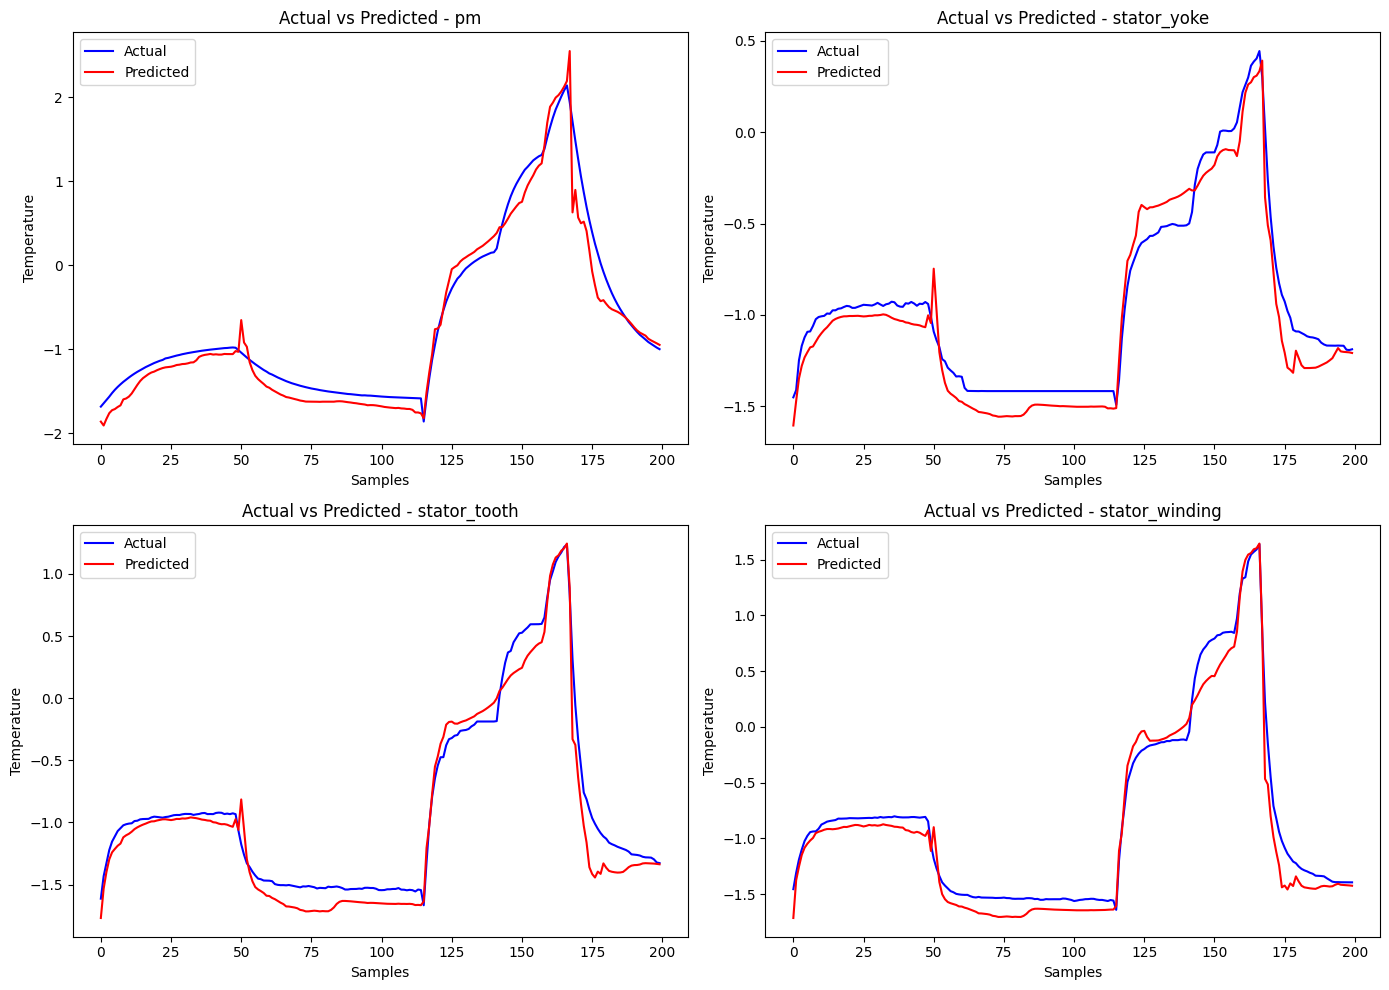

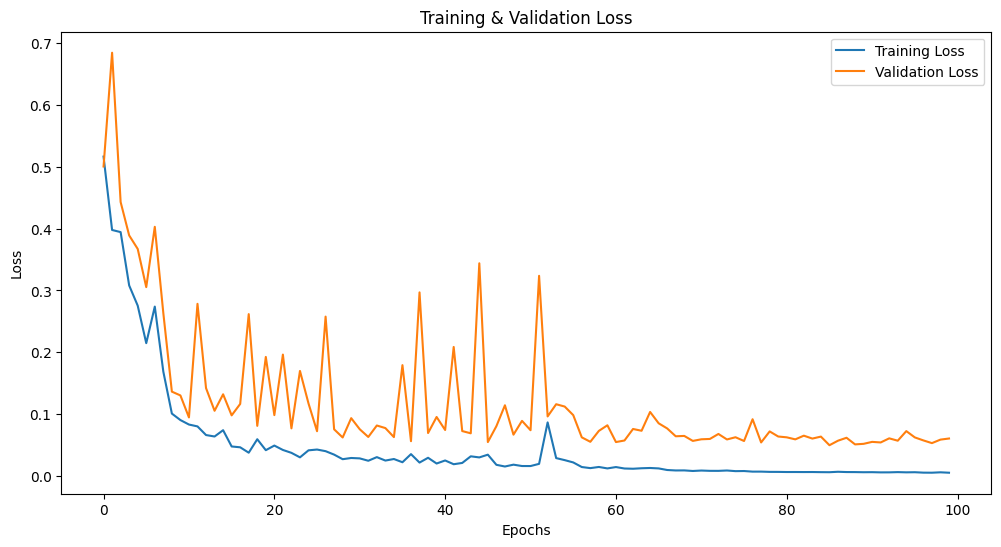

In [22]:
# Evaluate the model
test_loss, test_mae = tft_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}")

# Predict
y_pred = tft_model.predict(X_test)

# Optional: inverse transform (if using scalers)
# y_pred = target_scaler.inverse_transform(y_pred)
# y_test = target_scaler.inverse_transform(y_test)

import pickle

# Save training history to a file
with open('tft_model_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

# Define your target column names
target_cols = ["pm", "stator_yoke", "stator_tooth", "stator_winding"]

# Plot predictions vs actuals for each temperature
plt.figure(figsize=(14, 10))
for i, col in enumerate(target_cols):
    plt.subplot(2, 2, i + 1)
    plt.plot(y_test[:200, i], label='Actual', color='blue')
    plt.plot(y_pred[:200, i], label='Predicted', color='red')
    plt.title(f'Actual vs Predicted - {col}')
    plt.xlabel('Samples')
    plt.ylabel('Temperature')
    plt.legend()
plt.tight_layout()
plt.show()

# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss')
plt.show()


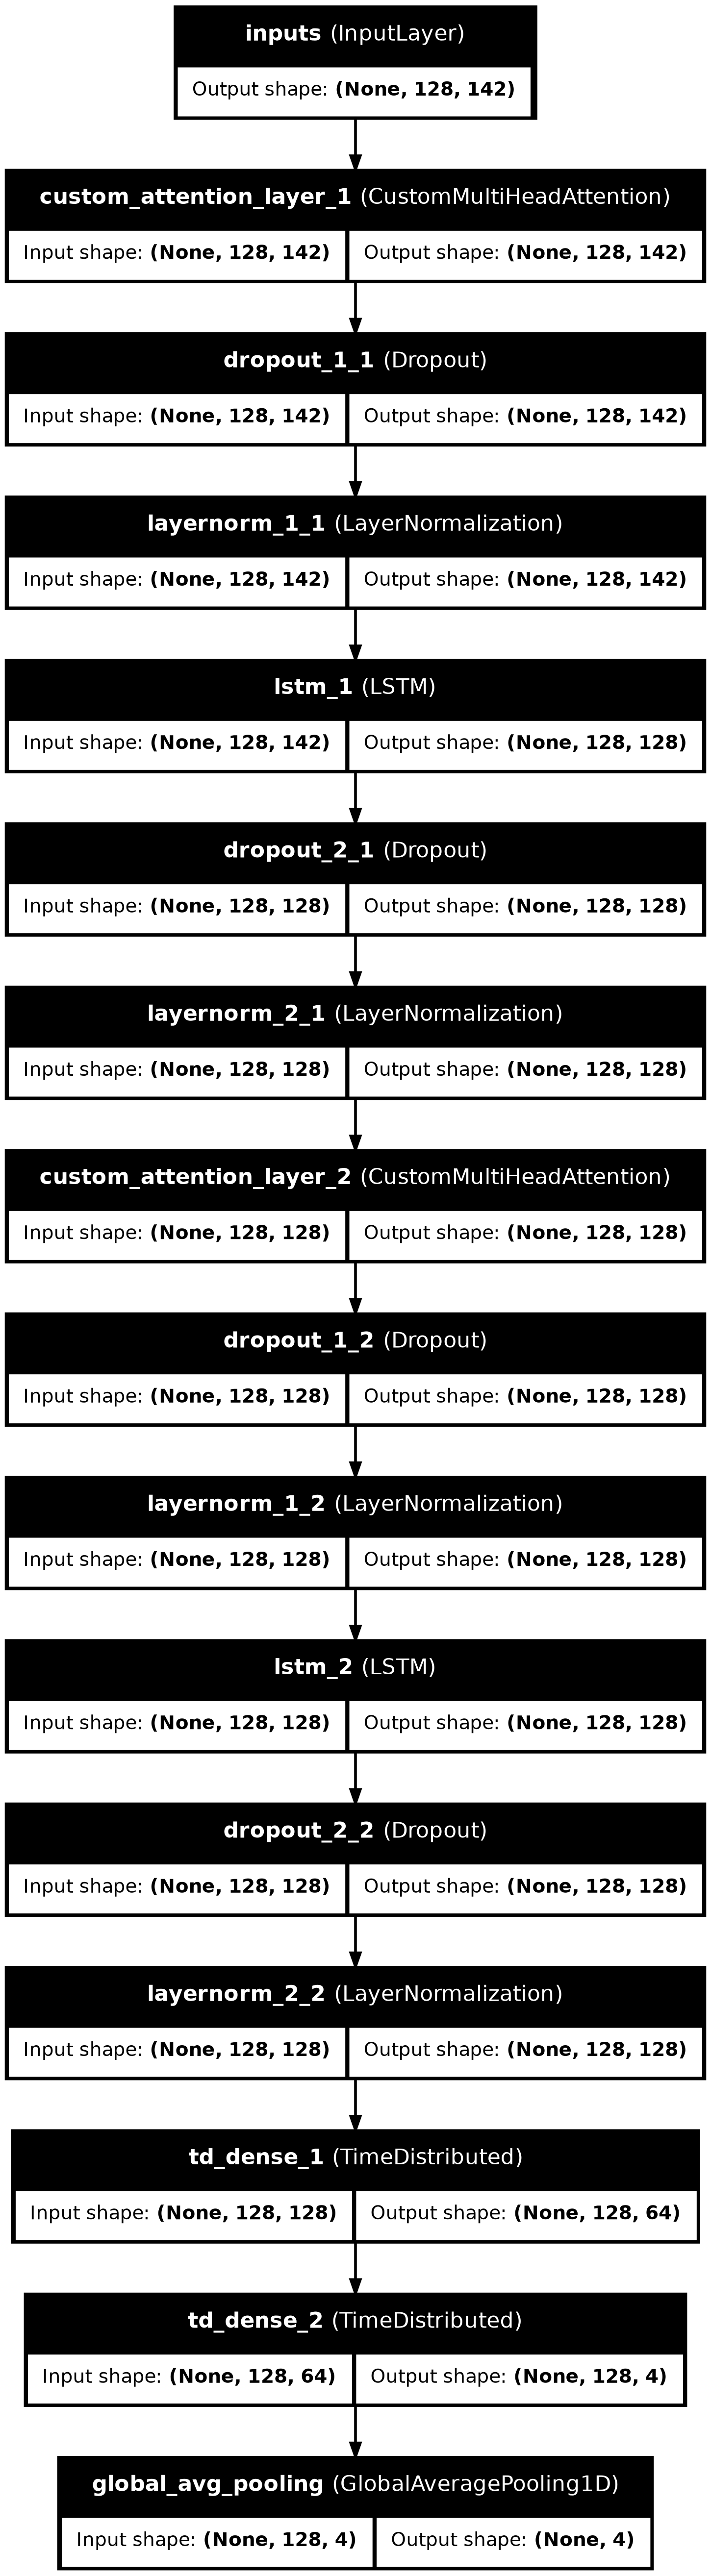

In [23]:
from tensorflow.keras.utils import plot_model

plot_model(tft_model, show_shapes=True, show_layer_names=True, to_file='tft_model.png')


In [ ]:
# Predict with attention
y_pred, attn_weights = tft_model.predict(X_test)

# Visualize attention of the first sample and first head
import seaborn as sns
import matplotlib.pyplot as plt

sample_idx = 0
head_idx = 0

attention = attn_weights[sample_idx, head_idx]  # shape: (seq_len, seq_len)

plt.figure(figsize=(10, 6))
sns.heatmap(attention, cmap='viridis')
plt.title(f'Attention Weights for Sample {sample_idx} - Head {head_idx}')
plt.xlabel('Key Time Steps')
plt.ylabel('Query Time Steps')
plt.show()


59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step


ValueError: too many values to unpack (expected 2)

In [ ]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import xgboost as xgb
import gc
import pickle
from sklearn.utils import resample

# Load the dataset
dataset = pd.read_csv('processed_dataset_base.csv')

# Define the 7 basic input features
basic_x_cols = ['ambient', 'coolant', 'u_d', 'u_q', 'motor_speed', 'i_d', 'i_q']
y_cols = ['pm', 'stator_yoke', 'stator_tooth', 'stator_winding']

# Prepare the dataset using only basic features
X = dataset[basic_x_cols]
y = dataset[y_cols]

# Ensure time series integrity by splitting using profile_id
train_profiles = dataset['profile_id'].unique().tolist()
for test_id in [78, 79, 81]:  
    if test_id in train_profiles:
        train_profiles.remove(test_id)

# Keep DataFrame properties (don't convert to NumPy)
X_train = X[dataset['profile_id'].isin(train_profiles)].copy()
y_train = y[dataset['profile_id'].isin(train_profiles)].copy()
X_test = X[dataset['profile_id'].isin([78, 79, 81])].copy()
y_test = y[dataset['profile_id'].isin([78, 79, 81])].copy()

# Handle missing values directly in DataFrame
X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)
y_train.fillna(0, inplace=True)
y_test.fillna(0, inplace=True)

# Initialize SHAP values dictionary
shap_values_dict = {}

# Train and analyze SHAP for each target variable
for target in y_cols:
    print(f"Training model for {target}...")
    
    model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=2019)
    model.fit(X_train, y_train[target])  # Now y_train is still a DataFrame, no indexing error
    
    # Calculate SHAP values
    print(f"Calculating SHAP values for {target}...")
    explainer = shap.TreeExplainer(model)
    
    # Use a subset of test data for efficiency (use resample instead of .sample())
    sample_size = min(1000, X_test.shape[0])
    X_test_sample = resample(X_test, n_samples=sample_size, random_state=2019)
    
    # Compute SHAP values
    shap_values = explainer(X_test_sample).values
    shap_values_dict[target] = shap_values
    
    # Generate SHAP summary plot
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X_test_sample, plot_type="bar", show=False)
    plt.title(f"Feature Importance for {target} (Basic 7 Features)")
    plt.tight_layout()
    plt.savefig(f"basic7/shap_summary_{target}_basic7.png", dpi=300, bbox_inches='tight')
    plt.close()
    
    # Generate SHAP dependence plots for top 3 features
    feature_importance = np.abs(shap_values).mean(0)
    top_features_idx = np.argsort(feature_importance)[-3:]  # Fix indexing
    top_features = [X_test_sample.columns[i] for i in top_features_idx]
    
    for feature in top_features:
        plt.figure(figsize=(8, 5))
        shap.dependence_plot(feature, shap_values, X_test_sample, show=False)
        plt.title(f"SHAP Dependence Plot for {target} - {feature}")
        plt.tight_layout()
        plt.savefig(f"basic7/shap_dependence_{target}_{feature}_basic7.png", dpi=300, bbox_inches='tight')
        plt.close()
    
    print(f"Completed SHAP analysis for {target}")
    gc.collect()

# Save SHAP values for later use
with open('basic7/shap_values_basic7.pkl', 'wb') as f:
    pickle.dump(shap_values_dict, f)

print("SHAP analysis complete for basic 7 features. Results saved.")


Training model for pm...
Calculating SHAP values for pm...
Completed SHAP analysis for pm
Training model for stator_yoke...
Calculating SHAP values for stator_yoke...
Completed SHAP analysis for stator_yoke
Training model for stator_tooth...
Calculating SHAP values for stator_tooth...
Completed SHAP analysis for stator_tooth
Training model for stator_winding...
Calculating SHAP values for stator_winding...
Completed SHAP analysis for stator_winding
SHAP analysis complete for basic 7 features. Results saved.


<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

In [ ]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import xgboost as xgb
import gc
import pickle
from sklearn.utils import resample

# Load the dataset
dataset = pd.read_csv('processed_dataset_base.csv')

# Define target columns
y_cols = ['pm', 'stator_yoke', 'stator_tooth', 'stator_winding']

# **Remove columns from x_cols that share a prefix with y_cols**
def remove_prefixed_columns(x_cols, y_cols):
    y_prefixes = tuple(f"{col}_" for col in y_cols)  # Add trailing underscore to match prefixes
    return [col for col in x_cols if not col.startswith(y_prefixes)]

# Identify x_cols, excluding targets and profile_id
all_cols = dataset.columns.tolist()
x_cols = [col for col in all_cols if col not in y_cols + ['profile_id']]
x_cols = remove_prefixed_columns(x_cols, y_cols)  # Remove prefixed columns

# Prepare the dataset
X = dataset[x_cols]
y = dataset[y_cols]

# Ensure time series integrity by splitting using profile_id
train_profiles = dataset['profile_id'].unique().tolist()
for test_id in [78, 79, 81]:  
    if test_id in train_profiles:
        train_profiles.remove(test_id)

# Keep DataFrame properties (don't convert to NumPy)
X_train = X[dataset['profile_id'].isin(train_profiles)].copy()
y_train = y[dataset['profile_id'].isin(train_profiles)].copy()
X_test = X[dataset['profile_id'].isin([78, 79, 81])].copy()
y_test = y[dataset['profile_id'].isin([78, 79, 81])].copy()

# Handle missing values directly in DataFrame
X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)
y_train.fillna(0, inplace=True)
y_test.fillna(0, inplace=True)

# Initialize SHAP values dictionary
shap_values_dict = {}

# Train and analyze SHAP for each target variable
for target in y_cols:
    print(f"Training model for {target}...")
    
    model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=2019)
    model.fit(X_train, y_train[target])  # Now y_train is still a DataFrame, no indexing error
    
    # Calculate SHAP values
    print(f"Calculating SHAP values for {target}...")
    explainer = shap.TreeExplainer(model)
    
    # Use a subset of test data for efficiency (use resample instead of .sample())
    sample_size = min(1000, X_test.shape[0])
    X_test_sample = resample(X_test, n_samples=sample_size, random_state=2019)
    
    # Compute SHAP values
    shap_values = explainer(X_test_sample).values
    shap_values_dict[target] = shap_values
    
    # Generate SHAP summary plot
    plt.figure(figsize=(10, 10))
    shap.summary_plot(shap_values, X_test_sample, plot_type="bar", show=False)
    plt.title(f"Feature Importance for {target} (Filtered Features)")
    plt.tight_layout()
    plt.savefig(f"shap_filtered/shap_summary_{target}.png", dpi=300)
    plt.close()
    
    # Generate SHAP dependence plots for top 3 features
    feature_importance = np.abs(shap_values).mean(0)
    top_features_idx = np.argsort(feature_importance)[-3:]  # Fix indexing
    top_features = [X_test_sample.columns[i] for i in top_features_idx]
    
    # for feature in top_features:
    #     plt.figure(figsize=(8, 5))
    #     shap.dependence_plot(feature, shap_values, X_test_sample, show=False)
    #     plt.title(f"SHAP Dependence Plot for {target} - {feature}")
    #     plt.tight_layout()
    #     plt.savefig(f"shap_filtered/shap_dependence_{target}_{feature}.png", dpi=300, bbox_inches='tight')
    #     plt.close()
    
    print(f"Completed SHAP analysis for {target}")
    gc.collect()

# Save SHAP values for later use
with open('shap_filtered/shap_values_filtered.pkl', 'wb') as f:
    pickle.dump(shap_values_dict, f)

print("SHAP analysis complete with filtered features. Results saved.")


Training model for pm...
Calculating SHAP values for pm...
Completed SHAP analysis for pm
Training model for stator_yoke...
Calculating SHAP values for stator_yoke...
Completed SHAP analysis for stator_yoke
Training model for stator_tooth...
Calculating SHAP values for stator_tooth...
Completed SHAP analysis for stator_tooth
Training model for stator_winding...
Calculating SHAP values for stator_winding...
Completed SHAP analysis for stator_winding
SHAP analysis complete with filtered features. Results saved.


In [ ]:
import pandas as pd
df = pd.read_csv("processed_dataset_base.csv")
df.head(10000).to_csv("sample_dataset.csv", index=False)
